<a href="https://colab.research.google.com/github/genaiconference/Agentic_KAG/blob/main/02_Traditional_RAG_%26_Agentic_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates the difference between Traditional RAG (Retrieval Augmented Generation) and Agentic RAG.

In [1]:
!git clone https://github.com/genaiconference/Agentic_KAG.git

Cloning into 'Agentic_KAG'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 30 (delta 10), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 323.98 KiB | 2.89 MiB/s, done.
Resolving deltas: 100% (10/10), done.


## Install Required Packages

In [2]:
!pip install -r /content/Agentic_KAG/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.7/189.7 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 59.7 MB/s eta

## Load credentials from .env

In [4]:
import os
os.chdir('/content/Agentic_KAG/')

from dotenv import load_dotenv

load_dotenv()  # This loads .env at project root

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

# Set OPENAI_API_KEY as env variable for openai/neo4j-graphrag compatibility
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

## Initialize OpenAI LLM and Embeddings via langchain_openai
We will use OpenAI **GPT-4.1** and **text-embedding-3-small** for the embedding model.

In [5]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# Initialize OpenAI LLM using LangChain
llm = ChatOpenAI(openai_api_key=OPENAI_API_KEY,
                 model_name="gpt-4.1",
                 temperature=0)

# Initialize OpenAI Embedding model using LangChain
embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY,
                              model="text-embedding-3-small")

## Load data

Load the data from the `page_data.pkl` file.


In [6]:
import pickle

with open("page_data.pkl", "rb") as f:
    pages = pickle.load(f)

## Create langchain documents

Convert the loaded data into LangChain `Document` objects.


In [7]:
from langchain_core.documents import Document

documents = []
for page in pages:
    doc = Document(page_content=page['content'], metadata={'url': page['url']})
    documents.append(doc)

print(f"Created {len(documents)} LangChain documents.")

Created 80 LangChain documents.


In [8]:
print(pages[0])

{'url': 'https://www.analyticsvidhya.com/datahacksummit', 'content': "# The AI Trinity\n\n## Powering the Future\n\n### Generative | Agentic | Responsible\n\n## India's Most Futuristic AI Conference\n\n### August 20-23, 2025  • The Leela Bhartiya City Bengaluru \n\nSend WhatsApp Updates\n\nDownload Agenda\n\nYour browser does not support the video tag. \n\n## 1200+\n\n### Attendees\n\n## 80+\n\n### AI Talks\n\n## 50+\n\n### Hack Sessions\n\n## 10+\n\n### Workshops\n\n## Hands-on AI Workshops\n\n### [Mastering Intelligent Agents: A Deep Dive into Agentic AI Dipanjan Sarkar - Analytics Vidhya  ](/datahacksummit-2025/workshops/mastering-intelligent-agents-a-deep-dive-into-agentic-ai-building-ai)\n\n[ 🔥 Most Trending Mastering Real-World Multi-Agent Systems Alessandro Romano - Kuehne+Nagel  ](/datahacksummit-2025/workshops/build-a-production-ready-multi-agent-application-with-crewai)\n\n[ Few Seats Left Agentic RAG Workshop: From Fundamentals to Real-World Implementations Arun Prakash Asok

## Create Custom Metadata

In [9]:
from urllib.parse import urlparse

def extract_section_from_url(url: str) -> str:
    path = urlparse(url).path
    parts = [p for p in path.strip("/").split("/") if p]

    if "datahacksummit-2025" in parts:
        parts.remove("datahacksummit-2025")

    if parts:
        return parts[0].replace("-", " ").title()
    else:
        return "Overview"

for item in documents:
  section = extract_section_from_url(item.metadata["url"])
  item.metadata['section'] = section

In [ ]:
print(documents[77])

page_content='Avinash Pathak [ ](https://www.linkedin.com/in/avipathak99/) Senior AI Engineer Avinash Pathak, Senior AI Engineer at NVIDIA, specializes in LLM Agents and LLM-based applications such as multimodal chatbots and GUI generation. With expertise spanning NLP and Large Language Models (LLMs), including seq2seq, LSTMs, BERT, and XLNET, he has also contributed to vision tasks like object detection and retail data analytics, developing models for the likelihood of buying and paying total price. His role at NVIDIA underscores his proficiency in cutting-edge AI technologies and his ability to innovate across diverse domains, exemplifying his commitment to advancing the field of artificial intelligence. He has two filed patents in the conversational AI field. Read more Hack Sessions Agent to Agent Protocol: Benefits and Workflows Avinash Pathak Senior AI Engineer The Agent2Agent (A2A) protocol addresses a critical challenge in the AI landscape: enabling gen AI agents, built on diver

## Create vector store

Create a vector store from the document chunks and the initialized embeddings.
We save this vector store in a persistent directory so that we can use it in future.


In [10]:
from langchain_community.vectorstores import Chroma

persist_directory = os.getcwd() +'/vectorstore/chroma/'

# Create the vector store
vectordb = Chroma.from_documents(
    documents=documents,
    embedding=embeddings,
    persist_directory=persist_directory
)

print(vectordb._collection.count())

80


## RAG Pipeline

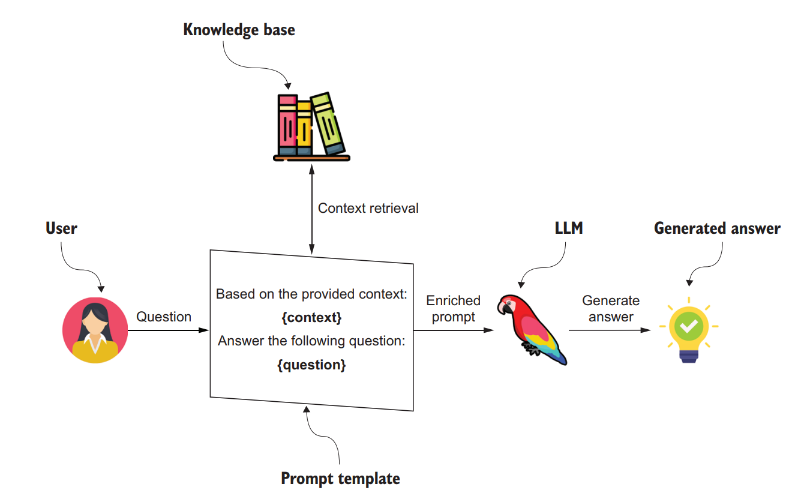

# Retrieval

Once the vector database is populated, you can define it as the retriever component, which fetches the additional context based on the semantic similarity between the user query and the embedded chunks.

To implement hybrid search with ChromaDB in LangChain, you combine vector similarity search and traditional keyword searches (like BM25) using an ensemble technique. Although ChromaDB itself does not have built-in hybrid search, LangChain allows you to blend different retrievers to achieve this effect.

In [14]:
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever

#Initialize ChromaDB Vector Store (Dense/Semantic Retriever)
similarity_search_retriever = vectordb.as_retriever(search_type="similarity",
                                     search_kwargs={"k": 5})

#Prepare BM25 Retriever (Keyword/Sparse Retriever)
bm25_retriever = BM25Retriever.from_documents(documents=documents, k=5)


#Create an Ensemble Retriever:Combine both the semantic (vector) and keyword (BM25) retrievers using EnsembleRetriever.
ensemble_retriever = EnsembleRetriever(
    retrievers=[similarity_search_retriever, bm25_retriever],
    weights=[0.5, 0.5]
)

# Augment
Next, to augment the prompt with the additional context, you need to prepare a prompt template. The prompt can be easily customized from a prompt template, as shown below.

In [15]:
from langchain.prompts import ChatPromptTemplate

template = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
Use three sentences maximum and keep the answer concise.
Avoid using generic phrases like "Provide context" or "as per context.

Question: {input}

Context: {context}

Answer:
"""
prompt = ChatPromptTemplate.from_template(template)

# Generate
Finally, you can build a chain for the RAG pipeline, chaining together the retriever, the prompt template and the LLM. Once the RAG chain is defined, you can invoke it.

In [16]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

# Create a chain to combine documents
combine_docs_chain = create_stuff_documents_chain(llm, prompt)

# Create a retrieval chain
rag_chain = create_retrieval_chain(ensemble_retriever, combine_docs_chain)

## Test Traditional RAG

Test the traditional RAG implementation with a sample query.

In [17]:
from IPython.display import Markdown

question = "Which topics are the most frequently covered across all sessions and workshops at DHS 2025?"
response = rag_chain.invoke({"input": question})

Markdown(response["answer"])

The most frequently covered topics at DHS 2025 are Agentic AI (including building, deploying, and monitoring AI agents and multi-agent systems), Large Language Models (LLMs) and their training, fine-tuning, and evaluation, as well as frameworks and best practices for operationalizing these systems (such as LangChain, CrewAI, and LangGraph). Additional recurring themes include Reinforcement Learning, Retrieval-Augmented Generation (RAG), AI system security (red teaming, risk mitigation), and real-world applications of generative AI. These topics are central across workshops, hack sessions, and panels throughout the event.

In [18]:
question = "List down all the sessions or workshops which uses LangGraph?"
response = rag_chain.invoke({"input": question})

Markdown(response["answer"])

The sessions and workshops that use LangGraph are:

1. Agentic RAG Workshop: From Fundamentals to Real-World Implementations
2. Agentic Knowledge Augmented Generation: The Next Leap After RAG
3. Mastering Agentic Workflows with LangGraph
4. LLMOps – Productionalizing Real-World Applications with LLMs and Agents (specifically in the "Multi-Agent Workflows with LangGraph" module)
5. AgentOps: Building and Deploying AI Agents (in modules on building agents and multi-agent systems with LangGraph)

## Test Agentic RAG

In [19]:
from langchain.agents import create_react_agent, AgentExecutor
import prompts
from langchain.tools import Tool
from langchain.prompts import (
    ChatPromptTemplate,
    MessagesPlaceholder,
    HumanMessagePromptTemplate,
    AIMessagePromptTemplate,
    PromptTemplate,
)

# Define the retriever as a tool
retriever_tool = Tool(
    name="AV_Agentic_RAG_tool",
    description="Useful for retrieving relevant documents based on input questions.",
    func=lambda query: ensemble_retriever.get_relevant_documents(query),
)

tools = [retriever_tool]

# Get the ReAct prompt
prompt = prompts.REACT_PROMPT


# Create the ReAct agent
def get_react_agent(llm, tools, system_prompt, verbose=False):
    """Helper function for creating agent executor"""
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="conversation_history", optional=True),
            HumanMessagePromptTemplate(
                prompt=PromptTemplate(input_variables=["input"], template="{input}")
            ),
            AIMessagePromptTemplate(
                prompt=PromptTemplate(
                    input_variables=["agent_scratchpad"], template="{agent_scratchpad}"
                )
            ),
        ]
    )
    agent = create_react_agent(llm, tools, prompt)
    return AgentExecutor(
        agent=agent,
        tools=tools,
        verbose=verbose,
        stream_runnable=True,
        handle_parsing_errors=True,
        max_iterations=5,
        return_intermediate_steps=True,
    )

generate_agent = get_react_agent(
        llm,
        tools,
        prompt,
        verbose=True,
    )

question = "Which topics are the most frequently covered across all sessions and workshops at DHS 2025?"
answer = generate_agent.invoke(
            {
                "input": question,
            }
        )
Markdown(answer["output"])



> Entering new AgentExecutor chain...
Thought: To answer this, I need to review the agenda or session/workshop listings for DHS 2025 and identify recurring topics.
Action: AV_Agentic_RAG_tool
Action Input: Most frequently covered topics across all sessions and workshops at DHS 2025

/tmp/ipython-input-2863241525.py:16: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  func=lambda query: ensemble_retriever.get_relevant_documents(query),


[Document(metadata={'url': 'https://www.analyticsvidhya.com/datahacksummit', 'section': 'Datahacksummit'}, page_content="# The AI Trinity\n\n## Powering the Future\n\n### Generative | Agentic | Responsible\n\n## India's Most Futuristic AI Conference\n\n### August 20-23, 2025  • The Leela Bhartiya City Bengaluru \n\nSend WhatsApp Updates\n\nDownload Agenda\n\nYour browser does not support the video tag. \n\n## 1200+\n\n### Attendees\n\n## 80+\n\n### AI Talks\n\n## 50+\n\n### Hack Sessions\n\n## 10+\n\n### Workshops\n\n## Hands-on AI Workshops\n\n### [Mastering Intelligent Agents: A Deep Dive into Agentic AI Dipanjan Sarkar - Analytics Vidhya  ](/datahacksummit-2025/workshops/mastering-intelligent-agents-a-deep-dive-into-agentic-ai-building-ai)\n\n[ 🔥 Most Trending Mastering Real-World Multi-Agent Systems Alessandro Romano - Kuehne+Nagel  ](/datahacksummit-2025/workshops/build-a-production-ready-multi-agent-application-with-crewai)\n\n[ Few Seats Left Agentic RAG Workshop: From Fundament

**Most Frequently Covered Topics at DHS 2025**

- **Agentic AI and AI Agents**
  - Building, deploying, and operationalizing intelligent agents and multi-agent systems are central themes across multiple workshops and sessions.
  - Topics include AgentOps, agent orchestration, agentic workflows, and best practices for real-world agentic AI systems.
  - Frameworks like LangChain, LangGraph, CrewAI, and AutoGen are frequently discussed and compared.
  - Example sessions: "Mastering Intelligent Agents: A Deep Dive into Agentic AI", "AgentOps: Building and Deploying AI Agents", "Mastering Real-World Multi-Agent Systems", "Building Effective Agentic AI Systems: Lessons from the Field", and "AutoGen vs CrewAI vs LangGraph: Battle of the Agent Frameworks"  
    [Source](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/mastering-intelligent-agents-a-deep-dive-into-agentic-ai-building-ai)

- **Large Language Models (LLMs)**
  - Training, fine-tuning, prompt engineering, and productionalizing LLMs are covered in depth.
  - Sessions address foundational concepts, advanced techniques (like RLHF, PEFT, LoRA), and operational challenges.
  - Example sessions: "Mastering LLMs: Training, Fine-Tuning, and Best Practices", "From Beginner to Expert: Learning LLMs, Reinforcement Learning & AI Agents", "LLMOps – Productionalizing Real-World Applications with LLMs and Agents"  
    [Source](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/mastering-llms-training-fine-tuning-and-best-practices-2)

- **Retrieval-Augmented Generation (RAG)**
  - RAG systems and their integration with agentic workflows are a recurring focus.
  - Example session: "Agentic RAG Workshop: From Fundamentals to Real-World Implementations"  
    [Source](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/agentic-rag-workshop-from-fundamentals-to-real-world-implemenno-title)

- **Generative AI**
  - Both technical and business applications of generative AI are explored, including for business leaders.
  - Example session: "Agentic AI & Generative AI for Business Leaders"  
    [Source](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/generative-ai-for-business-leaders)

- **Responsible and Safe AI**
  - Risk mitigation, governance, and responsible deployment of agentic and generative AI systems are discussed.
  - Example session: "Detecting and Mitigating Risks in Agentic AI"  
    [Source](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/detecting-and-mitigating-risks-in-agentic-aino-title)

- **Multi-Modal and Advanced Reasoning Models**
  - Integration of vision, speech, and language in agents, as well as advanced reasoning and inference techniques.
  - Example session: "Building Intelligent Multimodal Agents: Integrating Vision, Speech & Language", "Scaling Test-time Inference Compute & Advent of Reasoning Models"  
    [Source](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/building-a-multimodal-telegram-agent-that-sees-talks-and-thinks)

**Summary Table**

| Topic Area                | Example Sessions/Workshops                                                                                 |
|---------------------------|-----------------------------------------------------------------------------------------------------------|
| Agentic AI & Agents       | Mastering Intelligent Agents, AgentOps, Multi-Agent Systems, Agentic RAG, Agent Frameworks Battle         |
| LLMs                      | Mastering LLMs, LLMOps, Learning LLMs & RL, Prompt Engineering                                            |
| RAG                       | Agentic RAG Workshop, Operationalising LLMs                                                               |
| Generative AI             | Generative AI for Business Leaders, Generative AI concepts in agentic workshops                           |
| Responsible/Safe AI       | Detecting and Mitigating Risks in Agentic AI, Governance, Alignment                                       |
| Multi-Modal/Reasoning     | Multimodal Agents, Reasoning Models, Scaling Inference Compute                                            |

**Conclusion**
- The most frequently covered topics at DHS 2025 are Agentic AI and agents, LLMs, RAG, generative AI, responsible/safe AI, and advanced multi-modal/reasoning models. These themes are woven throughout the agenda in both technical and business-focused sessions and workshops  
  [Source](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/mastering-intelligent-agents-a-deep-dive-into-agentic-ai-building-ai).

In [20]:
question = "List down all the sessions or workshops which uses LangGraph??"
answer = generate_agent.invoke(
            {
                "input": question,
            }
        )
Markdown(answer["output"])



> Entering new AgentExecutor chain...
Thought: To answer this, I need to search for sessions or workshops that specifically mention the use of LangGraph.
Action: AV_Agentic_RAG_tool
Action Input: sessions or workshops that use LangGraph[Document(metadata={'url': 'https://www.analyticsvidhya.com/datahacksummit-2025/speakers/arun-prakash-asokan-2', 'section': 'Speakers'}, page_content='Arun Prakash Asokan [ ](https://www.linkedin.com/in/arunprakashasokan/) Associate Director Data Science Arun Prakash Asokan, an esteemed AI thought leader and Intrapreneur, holds over 16 years of experience driving comprehensive AI programs across diverse domains. Recognized as a Scholar of Excellence from the Indian School of Business, he seamlessly integrates academic rigor with practical expertise, holding a Master\'s in Computer Science Engineering from BITS Pilani and completing an Advanced Management Program from ISB Hyderabad. Arun\'s passion for building AI products is evident through his leaders

**Sessions and Workshops Using LangGraph**

---

- **Agentic RAG Workshop: From Fundamentals to Real-World Implementations**
  - Focus: Deep dive into Agentic RAG, building agentic workflows using LangGraph and LangChain.
  - Details: Hands-on modules, practical enterprise-grade tips, and full-scale agentic RAG application.
  - [Read More](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/agentic-rag-workshop-from-fundamentals-to-real-world-implemenno-title)

---

- **LLMOps – Productionalizing Real-World Applications with LLMs and Agents**
  - Focus: End-to-end LLMOps, including multi-agent workflows with LangGraph.
  - Details: Includes a dedicated module and lab on building multi-agent workflows using LangGraph.
  - [Read More](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/llmops-productionalizing-real-world-applications-with-llms-2)

---

- **Building Intelligent Multimodal Agents: Integrating Vision, Speech & Language**
  - Focus: Building a multimodal Telegram agent, managing workflows with LangGraph and LangGraph Studio.
  - Details: Covers agent memory, speech, vision, and real-time integration using LangGraph as the backbone.
  - [Read More](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/building-a-multimodal-telegram-agent-that-sees-talks-and-thinks)

---

- **Hack Session: Agentic Knowledge Augmented Generation: The Next Leap After RAG**
  - Focus: Building knowledge graphs, using graph databases, and designing autonomous AI agents with LangGraph.
  - [Read More](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/agentic-knowledge-augmented-generation-the-next-leap-after-rag)

---

- **Hack Session: Mastering Agentic Workflows with LangGraph**
  - Focus: Building graph-based LLM workflows, agent architectures, reflexion loops, and agentic RAG using LangGraph.
  - [Read More](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/building-intelligent-workflows-with-langgraph-from-agent-fundamentals)

---

- **Hack Panel: AutoGen vs CrewAI vs LangGraph: Battle of the Agent Frameworks**
  - Focus: Live demos and panel discussion comparing LangGraph with other agent frameworks.
  - [Read More](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/autogen-vs-crewai-vs-langgraph-battle-of-the-agent-frameworks)

---

- **Hack Session: Beyond PoCs: Building Real-World Agentic Systems**
  - Focus: Fundamentals of agents, Agentic RAG, and productionizing agentic systems using LangGraph.
  - [Read More](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/beyond-pocs-building-real-world-agentic-systems)

---

**Summary Table**

| Session/Workshop Title                                                                 | LangGraph Usage Area                | Link                                                                                                    |
|----------------------------------------------------------------------------------------|-------------------------------------|---------------------------------------------------------------------------------------------------------|
| Agentic RAG Workshop: From Fundamentals to Real-World Implementations                  | Agentic RAG, agent orchestration    | [Details](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/agentic-rag-workshop-from-fundamentals-to-real-world-implemenno-title) |
| LLMOps – Productionalizing Real-World Applications with LLMs and Agents                | Multi-agent workflows               | [Details](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/llmops-productionalizing-real-world-applications-with-llms-2)          |
| Building Intelligent Multimodal Agents: Integrating Vision, Speech & Language          | Multimodal agent orchestration      | [Details](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/building-a-multimodal-telegram-agent-that-sees-talks-and-thinks)       |
| Agentic Knowledge Augmented Generation: The Next Leap After RAG (Hack Session)         | Knowledge graphs, agent navigation  | [Details](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/agentic-knowledge-augmented-generation-the-next-leap-after-rag)         |
| Mastering Agentic Workflows with LangGraph (Hack Session)                              | Agentic workflows, reflexion loops  | [Details](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/building-intelligent-workflows-with-langgraph-from-agent-fundamentals)  |
| AutoGen vs CrewAI vs LangGraph: Battle of the Agent Frameworks (Hack Panel)            | Framework comparison, live demo     | [Details](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/autogen-vs-crewai-vs-langgraph-battle-of-the-agent-frameworks)          |
| Beyond PoCs: Building Real-World Agentic Systems (Hack Session)                        | Real-world agentic systems          | [Details](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/beyond-pocs-building-real-world-agentic-systems)                        |

---

**All the above sessions and workshops explicitly use LangGraph as a core part of their content or demonstrations.**